## Tutorial Notebook For Dynamic Time Warping Module

- `Dynamic time warping (DTW)` is an algorithm that allows finding an optimum match between two given numerical sequences (e.g. time-dependent series), where measuring of similarity between the sequences is sensitive to distortion or incomplete expression of the detected patterns.

### Import Libraries

In [1]:
#import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from core.analysis_convert import Analysis
from dynamic_time_warping.DTW import dtw

### Basic Usage
#### Generate random well log Data
For our purpose, we will generate random Density log data. Since I have only generated random numbers for this log, these numbers have no physical meaning whatsoever. **This is only for display purpose!**

Text(0.5, 0, 'g/cc')

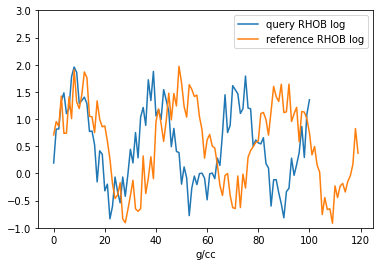

In [2]:
np.random.seed(1234)
# Generate log data
RHOB_well_1 = np.sin(2*np.pi*3.1*np.linspace(0,1,101))
RHOB_well_1 += np.random.rand(RHOB_well_1.size)
RHOB_well_2 = np.sin(2*np.pi*3*np.linspace(0,1,120))
RHOB_well_2 += np.random.rand(RHOB_well_2.size)

plt.plot(RHOB_well_1,label="query RHOB log")
plt.plot(RHOB_well_2,label="reference RHOB log")
plt.legend()
plt.ylim(-1,3)
plt.xlabel("g/cc")

In [3]:
# perform correlation using dynamic time warping.
"""
Note: The first run takes a few seconds for jit compilation.
"""
res = dtw(RHOB_well_1,RHOB_well_2)

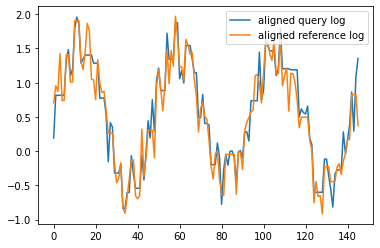

In [4]:
##Plot aligned logs
##Note: In this case, the sine waves are used as examples for actual logs.
res.plot_aligned_logs(query=RHOB_well_1,reference=RHOB_well_2)

- ``distance``" the minimum global distance computed, *not* normalized.
- ``normalizedDistance``: distance computed, *normalized* for path.
- if you want to calculate only dynamic time warp (dtw) distance (i.e. no need to gain alignment path),
give 'distance_only' argument as True (it makes faster).

In [5]:
# dtw distance
print("dtw distance: {}".format(res.distance))
print("dtw normalized distance: {}".format(res.normalized_distance))

dtw distance: 30.04881265458317
dtw normalized distance: 0.13596747807503698


### Usage with respect to stratigraphic correlation of well logs.

- Correlation of wireline logs is a standard method used in construction of regional stratigraphic models and in detailed reservoir units correlations.

- The `dtw` algorithm calculates the cost of correlating each point in the first well with each of the points in the second well. The resulting matrix of dissimilarity contains cost information about every possible operation which matches the well logs.
- The cost of matching the two wells is measured by the difference in the log values.
- This approach allows correlation across geologic structures, thinning beds, and missing or discontinuous units. 
    - A path finding algorithm then traces through the matrix to define a function which maps the first well onto the second. The minimum cost path is the optimal correlation between the wells.

In [17]:
#import well log data
instance = Analysis()
well_1 =instance.read_file(filename="data/wellx1.csv")
well_2 =instance.read_file(filename="data/wellx2.csv")
#correlate Gamma ray log using Dynamic Time Warp
w1=well_1['GR'][2000:3000]
w2=well_2['GR'][:1500]
#compute alignment vector
res = dtw(w1,w2)
#obtain alignmnet indices
alignmnet_indices= res.path



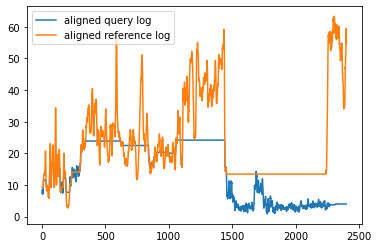

In [19]:
res.plot_aligned_logs(query=w1,reference=w2)

### Alignment Path

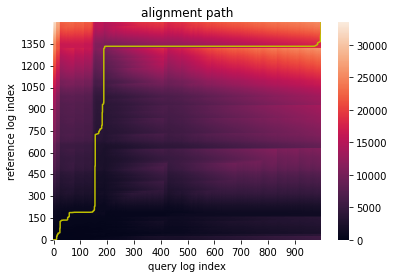

In [18]:
# visualize alignment path with cumsum cost matrix
res.plot_path()

- Methods for plotting stratigraphic correlation using dynamic time warp alignment objects.

- Various plotting styles are available, passing strings to the ``type``.

-  ``alignment`` plots the warping curve.
-  ``threeway`` vis-a-vis inspection of the logs and their warping
   curve.

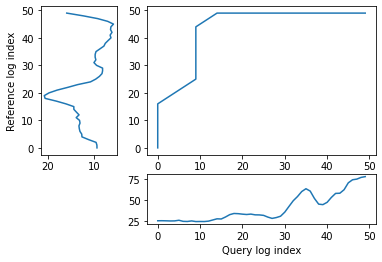

<AxesSubplot:>

In [8]:
#Plot warp curve with respective logs.
res.dtw_plot(query=w1,reference=w2, type='threeway')

### Partial Alignment

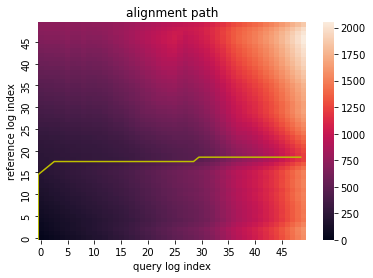

In [9]:
# open end
res = dtw(w1,w2,open_end=True)
res.plot_path()

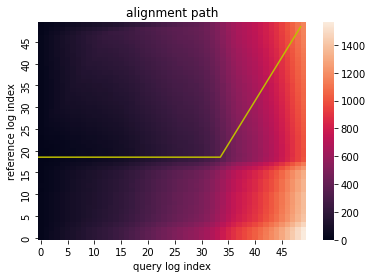

In [10]:
# open begin
res = dtw(w1,w2,step_pattern="asymmetric",open_begin=True)  # open-begin requires "N" normalizable pattern
res.plot_path()

#### Use another distance based metric

In [11]:
"""
you can choose arbitrary metric in scipy.spatial.distance.cdist
"""
res = dtw(w1,w2,dist="minkowski")
print("\nMinkowski metric:")
print("dtw distance: {}".format(res.distance))
print("dtw normalized distance: {}".format(res.normalized_distance))

"""
arbitrary function which returns distance value between x and y is also available
"""
res = dtw(w1,w2,dist=lambda x,y: np.abs(x-y))


Minkowski metric:
dtw distance: 1861.6059999999998
dtw normalized distance: 18.616059999999997


#### Use a pre-computed distance matrix

In [12]:
# calculate pair-wise distance matrix in advance
from scipy.spatial.distance import cdist
distance_matrix = cdist(w1[:,np.newaxis],w2[:,np.newaxis],metric="euclidean")
distance_matrix

C:\Users\ALEXANDER\AppData\Local\Temp\ipykernel_1032\2138225421.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  distance_matrix = cdist(w1[:,np.newaxis],w2[:,np.newaxis],metric="euclidean")


array([[16.316, 16.302, 16.119, ..., 16.456, 13.351,  9.781],
       [16.374, 16.36 , 16.177, ..., 16.514, 13.409,  9.839],
       [16.26 , 16.246, 16.063, ..., 16.4  , 13.295,  9.725],
       ...,
       [66.103, 66.089, 65.906, ..., 66.243, 63.138, 59.568],
       [68.129, 68.115, 67.932, ..., 68.269, 65.164, 61.594],
       [69.081, 69.067, 68.884, ..., 69.221, 66.116, 62.546]])

#### Use a user defined window

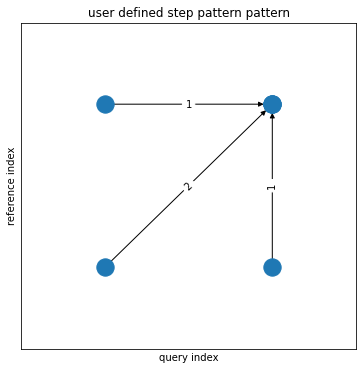

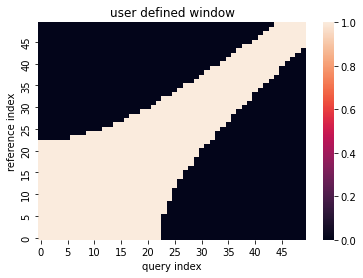

In [13]:
# define local constraint(step pattern)

from dynamic_time_warping.window import UserWindow
from dynamic_time_warping.step_pattern import UserStepPattern
pattern_info = [
                    dict(
                        indices=[(-1,0),(0,0)],
                        weights=[1]
                    ),
                    dict(
                        indices=[(-1,-1),(0,0)],
                        weights=[2]
                    ),
                    dict(
                        indices=[(0,-1),(0,0)],
                        weights=[1]
                    )
                ]
user_step_pattern = UserStepPattern(pattern_info=pattern_info,normalize_guide="N+M")

# define global constraint(window)
user_window = UserWindow(distance_matrix.shape[0],distance_matrix.shape[1],win_func=lambda i,j: np.abs(i**2-j**2) < 500)

# plot defined step-pattern and window.
user_step_pattern.plot()
user_window.plot()

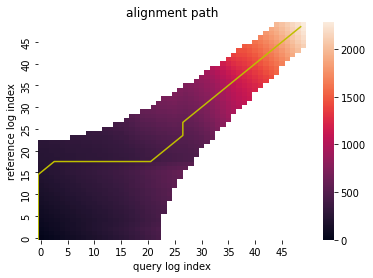

In [14]:
from dynamic_time_warping.DTW import dtw_low
res = dtw_low(distance_matrix,window=user_window,pattern=user_step_pattern)
res.plot_path()